In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from skimage.filters.rank import entropy
from skimage.morphology import disk
from matplotlib import pyplot as plt
from skimage import io
from skimage.filters import sobel
from scipy import ndimage as nd

import random
import seaborn as sns
import os
import cv2
import numpy as np
import torch
import pandas as pd
import glob

In [2]:
train_path='Brain-Tumor/Training/'
test_path='Brain-Tumor/Testing/'

In [3]:
image_train=[]
lables_train=[]
num=0
for dir_path in glob.glob(train_path+"/*"):
    #Label of all the directories in the training directory
    label = dir_path.split("\\")[-1]
    num+=1
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):

        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.resize(img, (150, 150)) #Resize images
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        image_train.append(img)
        lables_train.append(label)

        
image_train = np.array(image_train)
lables_train = np.array(lables_train)

In [4]:
image_test=[]
lables_test=[]

for dir_path in glob.glob(test_path+"/*"):
    #Label of all the directories in the training directory
    label = dir_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.resize(img, (150, 150)) #Resize images
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        image_test.append(img)
        lables_test.append(label)
        
        
image_test = np.array(image_test)
lables_test = np.array(lables_test)

In [5]:
#Encode the labels 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(lables_test)
test_labels_coded = le.transform(lables_test)
le.fit(lables_train)
train_labels_coded = le.transform(lables_train)

In [6]:
x_train, y_train, x_test, y_test = image_train, train_labels_coded, image_test, test_labels_coded

In [7]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
def FeatureExtractor(dataset):
    image_dataset=pd.DataFrame()
    #Looping through all the images: x_train.shape[0] contains the size of the dataset.
    for image in range(dataset.shape[0]):
        #Capturing data for each image
        df = pd.DataFrame()
        img=dataset[image, :,:,:]
    
    #Feature Extraction
        
        #Pixel Value Feature
        pix_val= img.reshape(-1)
        df['Pixel Value']= pix_val
        
        #Sobel Feature: Edge Detection Feature
        sobel_img=sobel(img)
        Sobel1=sobel_img.reshape(-1)
        df['Sobel']=Sobel1
        
        #MEDIAN with sigma=3
        median_img = nd.median_filter(img, size=3)
        median_img1 = median_img.reshape(-1)
        df['Median s3'] = median_img1
        
        #Gabor Fature 
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1,2):
                for lamda in np.arange(0, np.pi, np.pi/4):
                    #for gamma in (0.05,0,5):
                    gamma=0.5 
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)

                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df['Gabor' +str(num)] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    num += 1  #Increment for gabor column label


        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)        
    return image_dataset

In [9]:
part1=x_train[0:430]
part2=x_train[830:1250]
part3=x_train[1650:2030]
part4=x_train[2100:2430]

In [10]:
part11=y_train[0:430]
part22=y_train[830:1250]
part33=y_train[1650:2030]
part44=y_train[2100:2430]

In [11]:
img1=FeatureExtractor(part1)

In [12]:
img2=FeatureExtractor(part2)

In [13]:
img3=FeatureExtractor(part3)

In [14]:
img4=FeatureExtractor(part4)

In [15]:
image_features=pd.concat([img1, img2, img3, img4], axis=0)

In [16]:
image_features.head()

,Pixel Value,Sobel,Median s3,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,Gabor10,Gabor11,Gabor12,Gabor13,Gabor14,Gabor15,Gabor16
0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
X=np.concatenate([part1, part2, part3, part4],axis=0)
len(X)

1560

In [18]:
Y=np.concatenate([part11, part22, part33, part44], axis=0)

In [19]:
#Reshape to a vector for SVM training
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (X.shape[0], -1))  #Reshape to #images, features

In [20]:
#Define the classifier
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [21]:
# Fit the model on training data
RF_model.fit(X_for_RF, Y) #For sklearn no one hot encoding

RandomForestClassifier(random_state=42)

In [22]:
#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = FeatureExtractor(x_test)

In [23]:
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

In [24]:
#Predict on test
test_prediction = RF_model.predict(test_for_RF)
#Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(lables_test, test_prediction))


Accuracy =  0.5939086294416244


In [25]:
print ("F1 Score = ", metrics.f1_score(lables_test, test_prediction, average='macro'))

F1 Score =  0.4625679723828755


<AxesSubplot:>

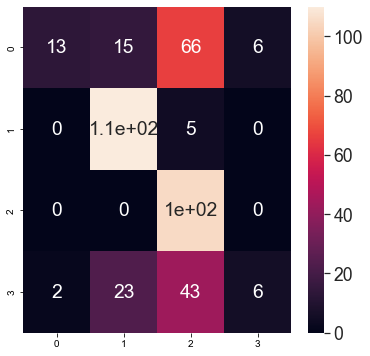

In [26]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(lables_test, test_prediction)
fig, axe = plt.subplots(figsize=(6,6))# Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=axe)